In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
from sklearn import preprocessing
from scipy.stats import rankdata
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import scipy.stats

from scipy.integrate import trapz

# Variational Dropout

## Data

In [2]:
def data_generating(traindf, testdf):
    # training set
    trainx = traindf.drop('median_house_value', axis=1).values
    trainy = traindf['median_house_value'].values
    # test set
    testx = testdf.drop('median_house_value', axis=1).values
    testy = testdf['median_house_value'].values
   
    scalerx = preprocessing.MinMaxScaler().fit(trainx)
    trainx = scalerx.transform(trainx) + 0.5
    testx = scalerx.transform(testx) + 0.5

    scalery = preprocessing.MinMaxScaler().fit(trainy.reshape(-1,1))
    trainy = scalery.transform(trainy.reshape(-1,1)).reshape(1, -1)
    testy = scalery.transform(testy.reshape(-1,1)).reshape(1, -1)
      
    
    # transfer data into tensor
    x = torch.tensor(trainx, dtype = torch.float)
    y = torch.tensor(trainy[0], dtype = torch.float)
    x_test = torch.tensor(testx, dtype = torch.float)
    y_test = torch.tensor(testy[0], dtype = torch.float)
    
    return x, y, x_test, y_test

In [3]:
# remove none value
df = pd.read_csv("housing.csv", sep=",")
df = df.dropna(axis=0)
# remove ocean_proximity
df = df.drop('ocean_proximity', axis = 1)
# split data into training and test set

msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
testdf = df[~msk]
x, y, x_test, y_test = data_generating(traindf, testdf)
num_data, num_feature = x.shape

## Define Model

In [4]:
def negativeKL(log_alpha):
    c1 = 1.16145124
    c2 = -1.50204118
    c3 = 0.58629921
    alpha = log_alpha.exp()
    negativeKL = 0.5 * log_alpha + c1 * alpha + c2 * alpha**2 + c3 * alpha**3
    
    return negativeKL

class MLP_VD(nn.Module):
    def __init__(self, size, max_log_alpha = -0.5):
        super(MLP_VD, self).__init__()
        self.size = size
        # set maximum log variance because we are using a wild approximation
        self.max_log_alpha = max_log_alpha
        # variational dropout for each node
        self.log_alpha = nn.ParameterList([nn.Parameter((torch.ones(size[i]) * 0.5).log()) for i in range(len(size) - 1)])
        # layer
        self.layers = nn.ModuleList([nn.Linear(size[i], size[i + 1]) for i in range(len(size) - 1)])
    
    def KL(self):
        KL = 0
        for i in range(len(self.log_alpha)):
            KL = KL - negativeKL(self.log_alpha[i]).sum() * self.size[i+1]
        return KL
    
    def forward(self, x):
        if self.training:
        
            # set limit to all variance
            for i in range(len(self.log_alpha)):
                self.log_alpha[i].data = torch.clamp(self.log_alpha[i].data, max=self.max_log_alpha)
            
            # forward pass
            for i, j in enumerate(self.layers):
                # generate noise for each layer
                epsilon = Variable(torch.randn(x.shape[0], self.size[i]))
                r = torch.randn(1)
                epsilon = 1 + self.log_alpha[i].exp() * epsilon
                if i != len(self.size) - 2:
                    x = F.relu(j(x * epsilon))
                else:
                    x = j(x * epsilon)
            return x
        else:
            for i, j in enumerate(self.layers):
                if i != len(self.size) - 2:
                    x = F.relu(j(x))
                else:
                    x = j(x)
            return x

## Training Model

In [5]:
# parameters
learning_rate = 0.001;
lambda_r1 = 0; lambda_r2 = 0;
batch_size = 50; num_epoch = 1000;
tolerance = 0.01; patience = 20;
#layers = [8, 50, 30, 1]
layers = [8,50,50,20,1]

In [6]:
# Training
def training_VD(mlp, x, y, x_test, y_test,learning_rate = 0.001, batch_size = 50, num_epoch=1000, tolerance=0.002, patience = 20):
    # Initialize training parameters
    parameters = set(mlp.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(parameters, lr = learning_rate)
    early_stop = EarlyStopping(tolerance, patience)
    
    train_errors = []
    val_errors = []
    model_KL = []
    
    num_data, num_dim = x.shape
    y = y.view(-1, 1)
    data = torch.cat((x, y), 1)
    
    # generate a random seed for training
    for epoch in range(num_epoch):
        # permuate the data
        data_perm = data[torch.randperm(len(data))]
        x = data_perm[:, 0:-1]
        y = data_perm[:, -1]
        mlp.train()
        for index in range(int(num_data/batch_size)):
            # data comes in
            inputs = x[index*batch_size : (index+1)*batch_size]
            labels = y[index*batch_size : (index+1)*batch_size].view(-1,1)
            
            # initialize the gradient of optimizer
            optimizer.zero_grad()

            # calculate the loss function
            outputs = mlp.forward(inputs)
            loss = criterion(outputs, labels)
            
            loss = loss + 0.1 * mlp.KL() / (num_data)
            
            # backpropogate the gradient
            loss.backward()
            # optimize with SGD
            optimizer.step()
        
        # do not use dropout during testing
        mlp.eval()
        
        # train and validation loss
        train_errors.append(criterion(mlp.forward(x), y.view(-1,1)))
        val_errors.append(criterion(mlp.forward(x_test), y_test.view(-1,1)))
        model_KL.append(mlp.KL())
        
        # determine if early stop
        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break
        
        if (epoch % 10) == 0:
            print('EPOACH %d: TRAIN LOSS: %.4f; VAL LOSS IS: %.5f; KL IS : %.5f'% (epoch+1, train_errors[epoch], val_errors[epoch], model_KL[epoch]))

                # save model
    torch.save(mlp.state_dict(), 'VD_mlp_01.pth')
    
    return mlp


In [7]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        if len(val_errors) < self.patience + 1:
            return False
        else:
            current_best = min(val_errors[:-self.patience])
            current_stop = True
            for i in range(self.patience):
                current_stop = current_stop and (val_errors[-i-1] - current_best > self.tolerance)
            return current_stop

In [8]:
mlp = MLP_VD(layers)
training_VD(mlp, x, y, x_test, y_test,learning_rate, batch_size, num_epoch, tolerance, patience)

EPOACH 1: TRAIN LOSS: 0.0501; VAL LOSS IS: 0.05145; KL IS : 68.56005
EPOACH 11: TRAIN LOSS: 0.0250; VAL LOSS IS: 0.02535; KL IS : 211.35593
EPOACH 21: TRAIN LOSS: 0.0220; VAL LOSS IS: 0.02213; KL IS : 322.27902
EPOACH 31: TRAIN LOSS: 0.0202; VAL LOSS IS: 0.02033; KL IS : 352.58453
EPOACH 41: TRAIN LOSS: 0.0200; VAL LOSS IS: 0.02009; KL IS : 395.82385
EPOACH 51: TRAIN LOSS: 0.0180; VAL LOSS IS: 0.01787; KL IS : 439.30515
EPOACH 61: TRAIN LOSS: 0.0178; VAL LOSS IS: 0.01781; KL IS : 467.51761
EPOACH 71: TRAIN LOSS: 0.0177; VAL LOSS IS: 0.01771; KL IS : 478.90176
EPOACH 81: TRAIN LOSS: 0.0178; VAL LOSS IS: 0.01790; KL IS : 487.86783
EPOACH 91: TRAIN LOSS: 0.0179; VAL LOSS IS: 0.01774; KL IS : 490.72577
EPOACH 101: TRAIN LOSS: 0.0173; VAL LOSS IS: 0.01721; KL IS : 493.36331
EPOACH 111: TRAIN LOSS: 0.0175; VAL LOSS IS: 0.01733; KL IS : 496.82394
EPOACH 121: TRAIN LOSS: 0.0168; VAL LOSS IS: 0.01677; KL IS : 496.40417
EPOACH 131: TRAIN LOSS: 0.0169; VAL LOSS IS: 0.01684; KL IS : 499.39270
EPOA

MLP_VD(
  (log_alpha): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 8]
      (1): Parameter containing: [torch.FloatTensor of size 50]
      (2): Parameter containing: [torch.FloatTensor of size 50]
      (3): Parameter containing: [torch.FloatTensor of size 20]
  )
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
)

## MC Sample 

In [9]:
# MC sample 
K_test = 100 # sample 100 times 
mlp.train() 
test = mlp(x_test)
MC_samples = [mlp(x_test) for _ in range(K_test)]  
# calculate the means 
means = torch.stack([tup for tup in MC_samples]).view(K_test, x_test.shape[0]).cpu().data.numpy()
print("menas.shape =" ,means.shape)
mean = np.mean(means, 0)
variational_uncertainty = np.std(means, 0)
# dropout_probability
#dropout_probability = np.array([torch.sigmoid(module.p_logit).cpu().data.numpy()[0] for module in mlp_cd_var.modules() if hasattr(module, 'p_logit')])

menas.shape = (100, 4015)


the area between two lines is =  0.2797820672478207


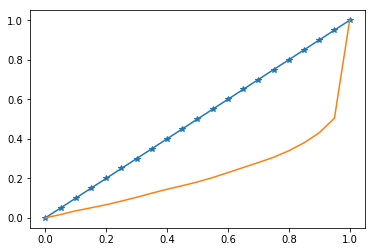

In [10]:
# hit probability
def hit_probability(y_test, mean, variational_uncertainty, confidence):
    confidence_lower, confidence_higher = scipy.stats.norm.interval(confidence , mean, variational_uncertainty)
#     print("confidence_higher = ", confidence_higher) 
#     print("y_test = ", y_test)
#     print("confidence_lower =",      confidence_lower)
    return np.sum([1 if y_test[i] <= confidence_higher[i] and y_test[i] >= confidence_lower[i] else 0 for i in range(len(y_test))]) / len(y_test)


confidence = np.linspace(0, 1.0, 21, endpoint = True)
plt.plot(confidence, confidence, '-*')

hit_ratio = [hit_probability(y_test, mean, variational_uncertainty, c) for c in confidence]
plt.plot(confidence, hit_ratio)

area1 = trapz(confidence, dx = 0.05)
area2 = trapz(hit_ratio, dx = 0.05)
print("the area between two lines is = ", area1 - area2)